# Project Zillow
A project to predict 2017 single family home prices.

## Imports

In [1]:
#imports for project zellow
import wrangle as wrg
import scipy.stats as stats
import pandas as pd
import auto_model3 as am3
import auto_model2a as am2a
import gen_wrangle1 as gwrg
import testing_models as tm
import os
import numpy as np

# Data viz:
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn stuff:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LassoLars
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import TweedieRegressor
from sklearn.metrics import  mean_squared_error
import warnings 
from math import sqrt


import env

## Acquire

* I downloaded from the sql server (May 14, 2023), saved a local copy of it as a csv file titled zillow_2017_project, 
and saved the data in a dataframe called zillow_2017.  
* There are 52,442 rows each representing a unique property. 
* There are 4 columns containing a range of property data.

In [2]:
#This necessary to run the function for the sql query and csv file
sql_query = sql_query = "select bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt, yearbuilt\
      from properties_2017 join predictions_2017 on properties_2017.parcelid = predictions_2017.parcelid where propertylandusetypeid = 261"
directory = os.getcwd()
url_for_query = wrg.get_db_url("zillow")
filename = "zillow_2017_project.csv"

In [3]:
#This function runs the sql query and creates a csv file
zillow_2017 = wrg.get_sql_data(sql_query, url_for_query, filename)

csv found and loaded


In [4]:
#a function that plots the distribtuiton of a target variable with a mean line
def plot_target_var(df_name, target_var):
    plt.hist(df_name[target_var])
    plt.axvline(df_name[target_var].mean(), color='k', linestyle='dashed', linewidth=1) 
    plt.title("Distribution of Home Values")
    plt.show() 

## Prepare

* Columns were converted from a float to an int when appropriate.
* The dataset contained 109 nulls and were dropped.
* The outliers representing the top %5 of home values were dropped. 
* The outliers of homes with more than 25000 square feet were dropped. 
* The data was split into 60% train, 20% validate, and 20% test segments. 

In [5]:
#This function reads the csv file and creates a dataframe
zillow_2017=wrg.wrangle_zillow(zillow_2017)

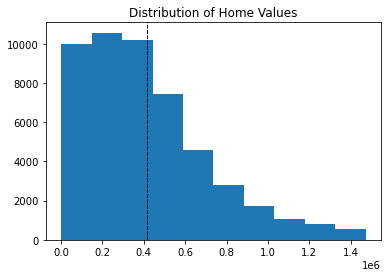

In [6]:
plot_target_var(zillow_2017,'value')

In [7]:
#This function splits the data into train, validate, and test
train_zillow, validate_zillow, test_zillow = wrg.split_function_cont_target(zillow_2017)

# Explore
## General Methodology 
### I started by first looking at each feature and to see how if and how much it would correlate with the target value (home value) with the appropriate statistical tests to validate. I went with the philosophy that more is better as low correlations would decrease the overall effectiveness of the regression model. 
 
# Exploration Questions
### Is there a significant correlation between any of the selected features and the target variable?
### Does combining rooms and bathrooms (highly correlated with each other) create a feature that is more correlated with value than the originals?


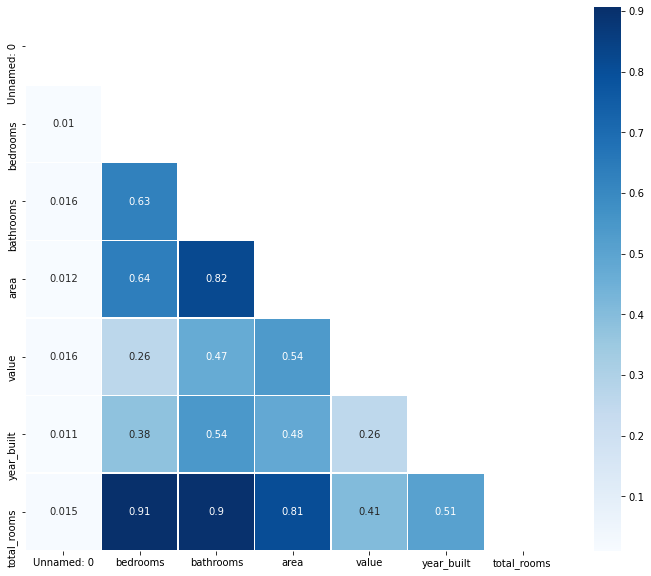

In [8]:
#This calls the function that creates a heatmap of the correlation between the variables
wrg.corr_heatmap(train_zillow)

### yes 
* With the top correlations being area, number of bathrooms, and total number of rooms.
* Total rooms has a correlation than just number of rooms. 

## Next Exploration Questions 
### Do the top features correlate according to statistical analysis?

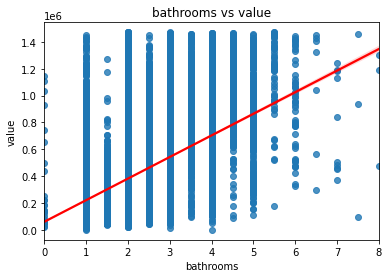

BATHROOMS and value
corr = 0.4393898284288099
p = 0.0
We reject the null hypothesis, there is a linear relationship between the variables



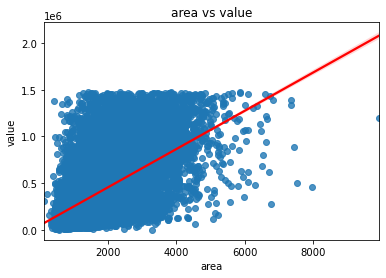

AREA and value
corr = 0.47870555601303366
p = 0.0
We reject the null hypothesis, there is a linear relationship between the variables



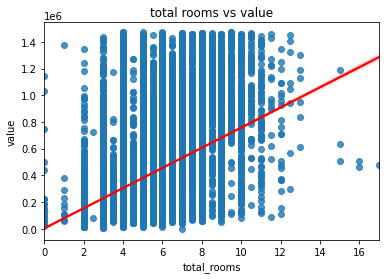

TOTAL_ROOMS and value
corr = 0.3820241423489157
p = 0.0
We reject the null hypothesis, there is a linear relationship between the variables



In [9]:
#This calls the function that runs a spearman correlation test add plots the results
wrg.spearman_loop(train_zillow, "value", cat_count=4)

### Yes 
- By using the spearman test we can show that there is a linear correlation between top features and the target variable and we can reject all null hypotheses.   

# Exploration conclusion
### None of the features explored returned high levels of correlation. Higher levels of correlation may be found within the geographical features (not used in the current form of this project) but would require additional research. I will not be using the number of rooms feature as it is represented in the total number of rooms feature and it has a low correlation. 

# Modeling 

In [10]:
#Sets up the x and y variables for the train, validate, and test dataframes
x_train, x_validate, x_test =train_zillow[["total_rooms","bathrooms","area"]], validate_zillow[["total_rooms","bathrooms","area"]], test_zillow[["total_rooms","bathrooms","area"]]
y_train, y_validate, y_test = train_zillow[["value"]], validate_zillow[["value"]], test_zillow[["value"]]

In [11]:
#scale the data
x_train_scaled, x_validate_scaled, x_test_scaled =wrg.scale_data(x_train, x_validate, x_test)

In [12]:
#function that runs the regression models
am3.auto_regress( y_train, train_zillow, x_train_scaled, x_validate_scaled, y_validate, x_test_scaled)

           model           RMSE       r^2
0  mean_baseline  299778.909266  0.000000
1          ols_1  249624.996319  0.287360
2          ols_2  247119.880671  0.301591
3           lars  247116.816033  0.301609
4           poly  246807.707219  0.303355
5            glm  253098.565969  0.267389


The best model is the poly model



/Users/olivertaylor/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


# Testing the Polynomial Model with a degree of 3

['Polynomial Model Test', 246311.75547456346, 0.3117614184645413]


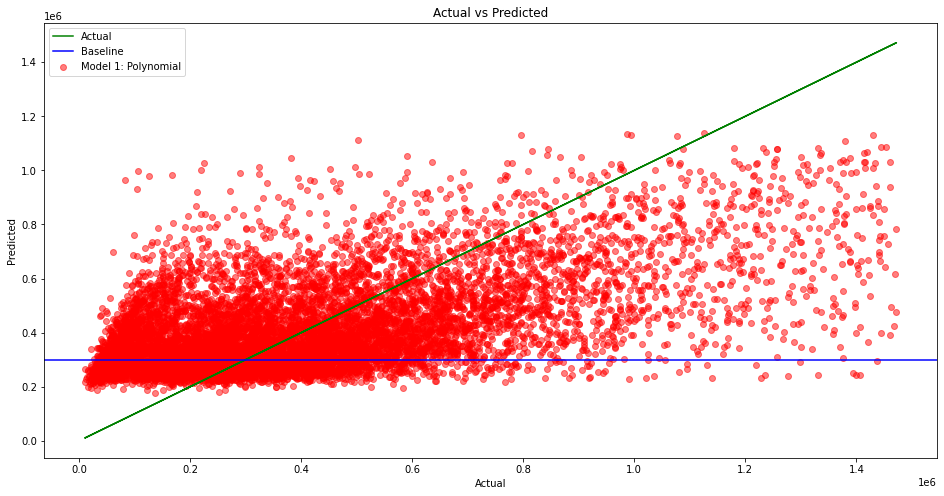

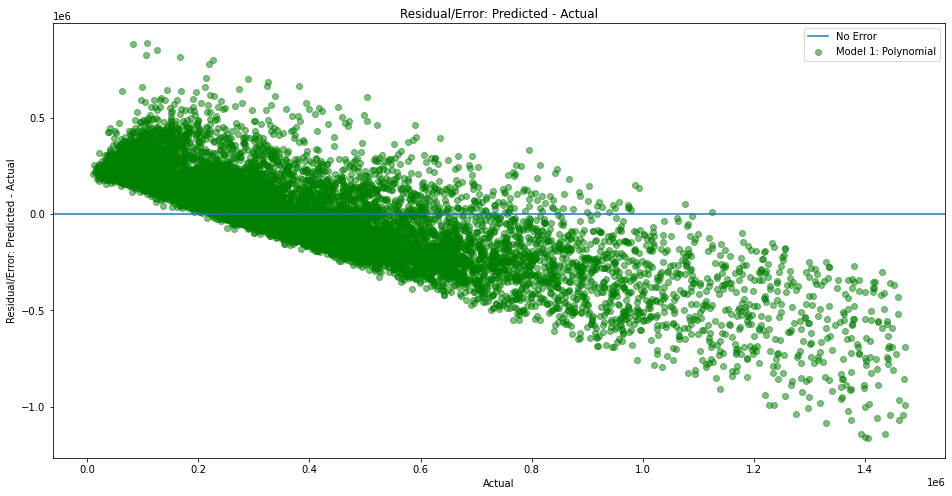

In [13]:
#calls the function that runs the polynomial test model
tm.test_poly_model(y_train, y_test, x_train_scaled,x_test_scaled)

In [14]:
#wrangle a new dataframe that has the value binned into 9 bins
zillow_2017_a=wrg.wrangle_zillow2(zillow_2017)
#sort the data by value_bins
zillow_2017_a.sort_values(by="value_bins")  
#the baseline for the zillow_2017_a dataframe
zillow_2017_a.value_bins.value_counts() / len(zillow_2017_a)   
#baseline is %16

200k-300k    0.165851
300k-400k    0.157244
100k-200k    0.155165
<100k        0.147363
400k-500k    0.137997
500k-600k    0.099211
600k-700k    0.072139
700k-800k    0.051908
800k-900k    0.013122
900k-1M      0.000000
1M-2M        0.000000
2M-3M        0.000000
3M-4M        0.000000
4M-5M        0.000000
Name: value_bins, dtype: float64

In [15]:
#splits the data into train, validate, and test
train_zillow_a, validate_zillow_a, test_zillow_a = gwrg.split_function_cat_target(zillow_2017_a, 'value_bins')

In [16]:
#sets up the x and y variables for the train, validate, and test dataframes
x_train, x_validate, x_test =train_zillow_a[["year_built","total_rooms","bathrooms","area"]], validate_zillow_a[["year_built","total_rooms","bathrooms","area"]], test_zillow_a[["year_built","total_rooms","bathrooms","area"]]
y_train, y_validate, y_test = train_zillow_a[["value_bins"]], validate_zillow_a[["value_bins"]], test_zillow_a[["value_bins"]]

# Testing the Random Forest Model with a depth of 10
## The baseline is 16%

In [17]:
#runs the random forest model
am2a.auto_random_trees_test(x_test, y_test, x_train, y_train)

/Users/olivertaylor/codeup-data-science/Zillow_2017_Project/auto_model2a.py:243: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train, y_train)



------------------------ Test Model with depth of 10 ------------------------------
             100k-200k    200k-300k    300k-400k    400k-500k   500k-600k  \
precision     0.271206     0.236737     0.196491     0.196970    0.226158   
recall        0.338617     0.240566     0.119403     0.084211    0.093468   
f1-score      0.301186     0.238636     0.148541     0.117981    0.132271   
support    1388.000000  1484.000000  1407.000000  1235.000000  888.000000   

            600k-700k   700k-800k  800k-900k        <100k  accuracy  \
precision    0.248092    0.253333        0.0     0.245386  0.240863   
recall       0.100775    0.122845        0.0     0.645186  0.240863   
f1-score     0.143330    0.165457        0.0     0.355546  0.240863   
support    645.000000  464.000000      117.0  1319.000000  0.240863   

             macro avg  weighted avg  
precision     0.208264      0.229075  
recall        0.193897      0.240863  
f1-score      0.178105      0.210409  
support    8947.0

## Accuracy is 24% beating the baseline of 16%

# Conclusion
### -We beat the line using the polynomial regression by approximately 53K and we predicted which property would fit into a $100k bucket within %24 accuracy.
### -The correlations between the features chosen and the target variable were not strong enough to get a significantly accurate regression model. With more features random forest or a similar model may be viable. 
### -Going forward more analysis contextual of the geographical data in the Zillow database is needed. Additionally, outside factors (interest rates, employment rates, etc) not captured in the Zillow database should be used to enhance future models.
